In [1]:
import sys
import csv
import os

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, f1_score
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from tqdm import tqdm


sys.path.append("../")
from src.graph_preprocessing import load_graph_data, create_graph
from src.features_extraction import (
    feature_extractor, graph_feature_extractor, run_graph_learning,
    metadata_features_extractor, abstract_extractor_reduced, abstract_extractor_complete, graph_learned_features_extractor
)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
with open("../data/node_information.csv", "r") as f:
    reader = csv.reader(f)
    node_info = list(reader)

nodes = [element[0] for element in node_info]

with open("../data/training_set.txt", "r") as f:
    reader = csv.reader(
        f,
        delimiter=" ",
    )
    train_dataset = list(reader)

full_graph = create_graph(nodes, train_dataset)

In [4]:
wv = run_graph_learning(full_graph)

In [5]:
sub_graph, residual_g, train_samples, train_labels, test_samples, test_labels = load_graph_data("../experiments/1.0_0.8")

In [6]:
features_method = [metadata_features_extractor, graph_feature_extractor, graph_learned_features_extractor, abstract_extractor_reduced]

train_features = feature_extractor(
    sub_graph, train_samples, 
    features_method, 
    node_information_path="../data/node_information.csv", wv=wv
)
test_features = feature_extractor(
    sub_graph, test_samples, 
    features_method, 
    node_information_path="../data/node_information.csv", wv=wv
)

100%|██████████| 133758/133758 [00:25<00:00, 5317.93it/s]


In [7]:
train_features.shape

(535038, 41)

# Classification

In [8]:
def make_classification_model(input_features):
    model = nn.Sequential(
            nn.Linear(input_features, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 1),
            nn.Sigmoid()
    )
    optimizer = torch.optim.Adam(model.parameters())
    loss_fn = nn.BCELoss()
    return model, optimizer, loss_fn

In [9]:
model, optimizer, loss_fn = make_classification_model(train_features.shape[1])

In [10]:
train_tensor_features = torch.Tensor(train_features)
train_tensor_labels = torch.Tensor(train_labels)[..., None]#.type(torch.LongTensor)

train_dataset = TensorDataset(train_tensor_features, train_tensor_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_tensor_features = torch.Tensor(test_features)
test_tensor_labels = torch.Tensor(test_labels)[..., None]#.type(torch.LongTensor)

test_dataset = TensorDataset(test_tensor_features,test_tensor_labels)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [11]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader)
    model.train()
    losses = []
    with tqdm(enumerate(dataloader), total=size) as pbar:
        for batch, (X, y) in enumerate(dataloader):
            # Compute prediction error
            pred = model(X)
            loss = loss_fn(pred, y)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            pbar.update(1)

            if batch % 100 == 0:
                losses.append(loss.item())
                pbar.set_description(str(loss.item()))
    return losses

In [12]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    model.eval()
    losses = []
    for batch, (X, y) in tqdm(enumerate(dataloader), total=size):
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        if batch % 100 == 0:
            losses.append(loss.item())
    return losses

In [13]:
train_losses = []
test_losses = []

num_epochs = 30

for epoch in range(num_epochs):
    print(f"Epoch {epoch}/{num_epochs}...")
    epoch_train_losses = train(train_loader, model, loss_fn, optimizer)
    epoch_test_losses = test(test_loader, model, loss_fn)
    train_losses.append(np.mean(epoch_train_losses))
    print("Train ", train_losses[-1])
    test_losses.append(np.mean(epoch_test_losses))
    print("Test ", test_losses[-1])

Epoch 0/30...


100%|██████████| 133758/133758 [00:08<00:00, 15083.30it/s]


Train  1.2684889679907687
Test  0.1107005772807524
Epoch 1/30...


100%|██████████| 133758/133758 [00:08<00:00, 15510.81it/s]


Train  0.16711121326079592
Test  0.07049630312880013
Epoch 2/30...


100%|██████████| 133758/133758 [00:08<00:00, 15398.70it/s]


Train  0.185404593831793
Test  0.06370936014979754
Epoch 3/30...


100%|██████████| 133758/133758 [00:08<00:00, 15461.40it/s]


Train  0.12411204040593778
Test  0.12129584792090504
Epoch 4/30...


100%|██████████| 133758/133758 [00:08<00:00, 16256.74it/s]


Train  0.1879513150058864
Test  0.0824097099748091
Epoch 5/30...


100%|██████████| 133758/133758 [00:08<00:00, 15743.62it/s]


Train  0.08822169752481084
Test  0.10797063380499843
Epoch 6/30...


100%|██████████| 133758/133758 [00:08<00:00, 16537.80it/s]


Train  0.10956491058736685
Test  0.06323887170637302
Epoch 7/30...


100%|██████████| 133758/133758 [00:07<00:00, 16746.58it/s]


Train  0.09266616638827448
Test  0.06633411346710139
Epoch 8/30...


100%|██████████| 133758/133758 [00:07<00:00, 16914.46it/s]


Train  0.10455042479415647
Test  0.08313234458440191
Epoch 9/30...


100%|██████████| 133758/133758 [00:08<00:00, 16278.15it/s]


Train  0.15609669147635855
Test  0.07055625322918609
Epoch 10/30...


100%|██████████| 133758/133758 [00:08<00:00, 16490.42it/s]


Train  0.08772219700594655
Test  0.06415416015941153
Epoch 11/30...


100%|██████████| 133758/133758 [00:08<00:00, 16539.55it/s]


Train  0.1028788017463826
Test  0.11850127432534506
Epoch 12/30...


100%|██████████| 133758/133758 [00:08<00:00, 16138.91it/s]


Train  0.07705066939871315
Test  0.07995238934552328
Epoch 13/30...


100%|██████████| 133758/133758 [00:08<00:00, 15484.07it/s]


Train  0.11287972709951213
Test  0.07830046254940153
Epoch 14/30...


100%|██████████| 133758/133758 [00:08<00:00, 15667.39it/s]


Train  0.09606962691205331
Test  0.0659259775618492
Epoch 15/30...


100%|██████████| 133758/133758 [00:08<00:00, 15801.85it/s]


Train  0.08449474471576866
Test  0.07429116418964765
Epoch 16/30...


100%|██████████| 133758/133758 [00:08<00:00, 16054.62it/s]


Train  0.08971262820081652
Test  0.06432308171760372
Epoch 17/30...


100%|██████████| 133758/133758 [00:08<00:00, 15978.48it/s]


Train  0.08197876390546471
Test  0.062194822373095454
Epoch 18/30...


100%|██████████| 133758/133758 [00:08<00:00, 16048.86it/s]


Train  0.08139686653157696
Test  0.06607728989827831
Epoch 19/30...


100%|██████████| 133758/133758 [00:08<00:00, 15448.28it/s]


Train  0.08725163110509693
Test  0.08192076061033705
Epoch 20/30...


100%|██████████| 133758/133758 [00:08<00:00, 16038.41it/s]


Train  0.1041294246623736
Test  0.08067389786529912
Epoch 21/30...


100%|██████████| 133758/133758 [00:08<00:00, 15766.20it/s]


Train  0.08384671686716112
Test  0.0634406285589446
Epoch 22/30...


100%|██████████| 133758/133758 [00:08<00:00, 15384.32it/s]


Train  0.07598415778539631
Test  0.31549965162667143
Epoch 23/30...


100%|██████████| 133758/133758 [00:08<00:00, 16223.50it/s]


Train  0.07689512117178224
Test  0.0658407702932002
Epoch 24/30...


100%|██████████| 133758/133758 [00:08<00:00, 16150.23it/s]


Train  0.0865981137834578
Test  0.06655332529578678
Epoch 25/30...


100%|██████████| 133758/133758 [00:08<00:00, 15897.16it/s]


Train  0.08992513806913935
Test  0.0728873326488304
Epoch 26/30...


100%|██████████| 133758/133758 [00:08<00:00, 16276.38it/s]


Train  0.07444410273871784
Test  0.07057061773642025
Epoch 27/30...


100%|██████████| 133758/133758 [00:08<00:00, 16608.07it/s]


Train  0.0885575353611438
Test  0.06605202578874333
Epoch 28/30...


100%|██████████| 133758/133758 [00:08<00:00, 15854.29it/s]


Train  0.07882623327618819
Test  0.08429064520494658
Epoch 29/30...


100%|██████████| 133758/133758 [00:08<00:00, 16130.06it/s]

Train  0.10845225103687317
Test  0.06369116043121559


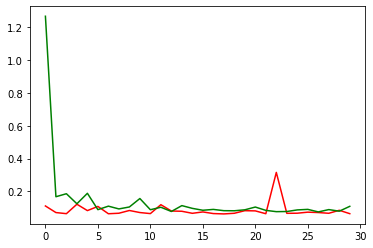

In [14]:
plt.plot(test_losses, c="r")
plt.plot(train_losses, c="g")

In [15]:
model.eval()
test_preds = [
    model(feature) for feature, label in test_loader
]

In [16]:
test_preds = torch.Tensor(test_preds).tolist()

In [17]:
fpr, tpr, thresholds = roc_curve(test_labels, test_preds)
roc_auc = roc_auc_score(test_labels, test_preds)

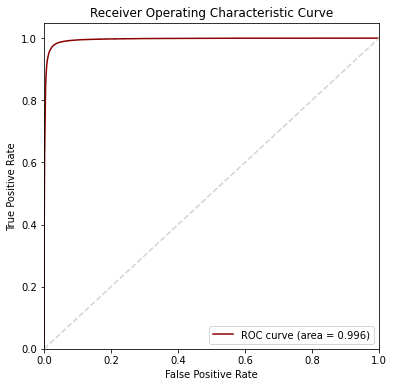

In [18]:
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkred', label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='lightgray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()

In [19]:
th = thresholds[np.argmax(tpr - fpr)]

In [20]:
#test_preds = lr.predict(test_features)
f1_score(test_labels, [pred > th for pred in test_preds])

0.9744695133320902

# Submissions

In [21]:
with open("../data/testing_set.txt", "r") as f:
    reader = csv.reader(f)
    samples = list(reader)

In [22]:
samples = [sample[0].split() for sample in samples]

In [23]:
with open("../data/node_information.csv", "r") as f:
    reader = csv.reader(f)
    node_info = list(reader)

nodes = [element[0] for element in node_info]

with open("../data/training_set.txt", "r") as f:
    reader = csv.reader(
        f,
        delimiter=" ",
    )
    train_dataset = list(reader)

graph = create_graph(nodes, train_dataset)

In [24]:
features = feature_extractor(
    graph, samples, 
    features_method, 
    node_information_path="../data/node_information.csv", wv=wv
)

100%|██████████| 32648/32648 [00:00<00:00, 347541.79it/s]


In [25]:
#submit_dataset = TensorDataset(features)
submit_loader = DataLoader(features, batch_size=1, shuffle=False)

In [26]:
model.eval()
submit_preds = [
    int(model(feature.float())[0].item() > th) for feature in submit_loader
]

In [27]:
submission_df = pd.DataFrame(dict(category=submit_preds))

In [28]:
submission_df = submission_df.reset_index()
submission_df.columns = ["id", "category"]

In [29]:
submission_df.to_csv("../submission5_with_textual_1.csv", index=None)